In [1]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

<h2>Алгоритм поиска дубликатов на изображении</h2>
Загрузим основную картинку (большую) и картинку цель (маленькую)

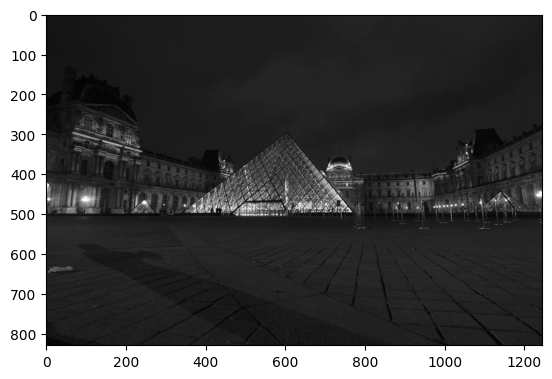

In [2]:
img1 = cv.imread('input.jpg', cv.IMREAD_GRAYSCALE) # основное (на чем ищем)
img2 = cv.imread('234.png', cv.IMREAD_GRAYSCALE) # побочное (что ищем)
plt.imshow(img1, cmap='gray')
# Участники Сольвеевского конгресса 1927 года,
# на котором обсуждались проблемы интерпретации квантовой механики
# Найдем Эйнштейна на данном фото

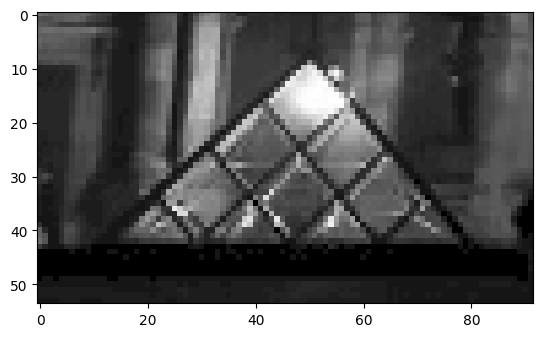

In [3]:
plt.imshow(img2, cmap='gray')

Детектором - это метод извлечения ключевых точек из изображения.
Создадим детектор и вычислим ключевые точки на изображениях img1 и img2

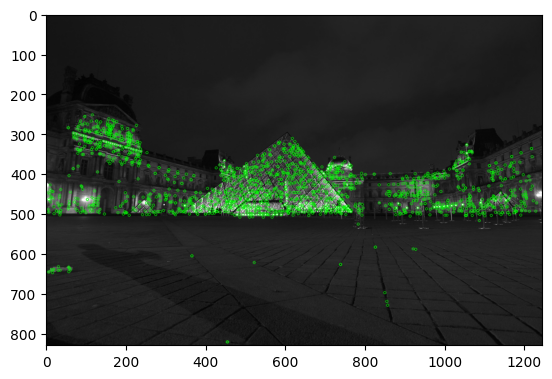

In [4]:
# Создаем SIFT детектор
sift = cv.SIFT_create()

# Находим ключевые точки с SIFT
kp1 = sift.detect(img1, None)
kp2 = sift.detect(img2, None)


img3 = cv.drawKeypoints(img1, kp1, None, color=(0,255,0), flags=0)
img4 = cv.drawKeypoints(img2, kp2, None, color=(0,255,0), flags=0)

img3_copy = img3
# Покажем найденные ключевые точки
plt.imshow(img3, cmap='gray')

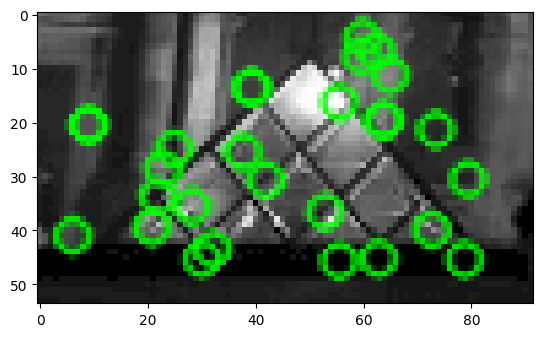

In [5]:
# Покажем найденные ключевые точки
plt.imshow(img4, cmap='gray')

Дескриптор — идентификатор ключевой точки, выделяющий её из остальной массы особых точек. В свою очередь, дескрипторы должны обеспечивать инвариантность нахождения соответствия между особыми точками относительно преобразований изображений.
Теперь вычислим дескрипторы SIFT (Scale Invariant Feature Transform).
В методе SIFT дескриптором является вектор. Как и направление ключевой точки, дескриптор вычисляется на гауссиане, ближайшем по масштабу к ключевой точке, и исходя из градиентов в некотором окне ключевой точки. Перед вычислением дескриптора это окно поворачивают на угол направления ключевой точки, чем и достигается инвариантность относительно поворота.

In [6]:
# Вычисляем дескрипторы с sift
kp1, des1 = sift.compute(img1, kp1)
kp2, des2 = sift.compute(img2, kp2)

FLANN означает «Быстрая библиотека для приближенных ближайших соседей». Он содержит набор алгоритмов, оптимизированных для быстрого поиска ближайших соседей в больших наборах данных и для многомерных объектов.
Для средства сопоставления на основе FLANN нам необходимо передать два словаря, в которых указан используемый алгоритм, связанные с ним параметры и т. д. Первый из них — IndexParams. Для различных алгоритмов передаваемая информация объясняется в документации FLANN. Подводя итог, для таких алгоритмов, как SIFT, SURF и т. д.
Второй словарь — SearchParams. Он указывает, сколько раз деревья в индексе должны быть рекурсивно пройдены. Более высокие значения дают лучшую точность, но также требуют больше времени. Если вы хотите изменить значение, передайте search_params = dict(checks=100).

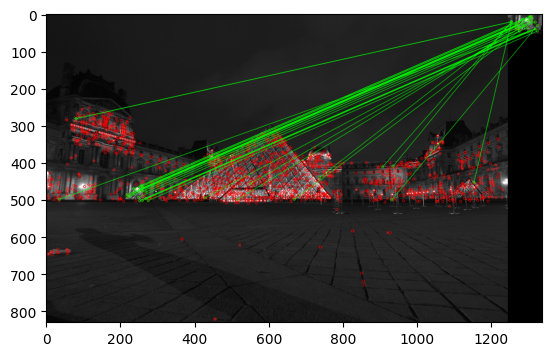

(<matplotlib.image.AxesImage at 0x15e03dbdab0>, None)

In [7]:
# параметры FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # или передать пустой словарь

flann = cv.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)

# Нужно рисовать только хорошие совпадения, поэтому создаем маску
matchesMask = [[0,0] for i in range(len(matches))]

# тест на соотношение согласно статье Лоу (D.Lowe in SIFT paper)
for i,(m,n) in enumerate(matches):
    if m.distance < 0.7*n.distance:
        matchesMask[i]=[1,0]

draw_params = dict(matchColor = (0,255,0),
                   singlePointColor = (255,0,0),
                   matchesMask = matchesMask,
                   flags = cv.DrawMatchesFlags_DEFAULT)

img3 = cv.drawMatchesKnn(img1,kp1,img2,kp2,matches,None,**draw_params)
plt.imshow(img3,),plt.show()

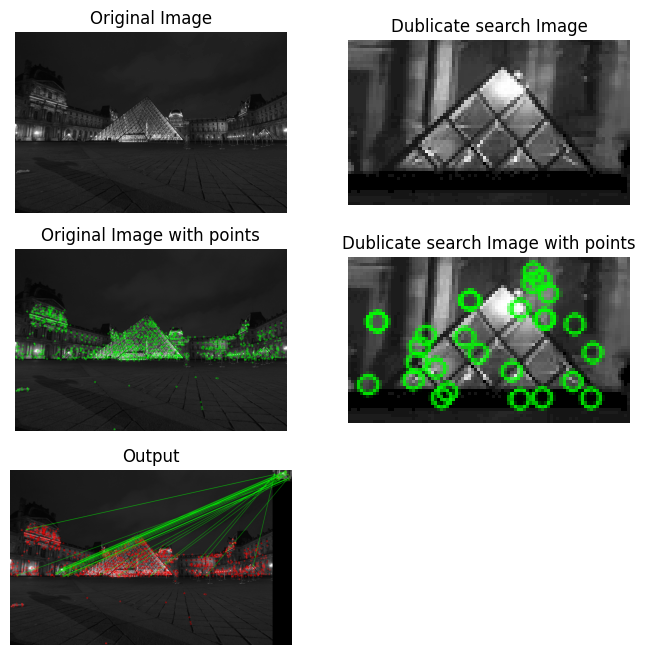

In [8]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, _)) = plt.subplots(nrows=3, ncols=2, figsize=(8, 8))
ax1.imshow(img1, cmap='gray')
ax1.set_title('Original Image')
ax1.axis('off')

ax2.imshow(img2, cmap='gray')
ax2.set_title('Dublicate search Image')
ax2.axis('off')


ax3.imshow(img3_copy, cmap='gray')
ax3.set_title("Original Image with points")
ax3.axis('off')

ax4.imshow(img4, cmap='gray')
ax4.set_title("Dublicate search Image with points")
ax4.axis('off')

ax5.imshow(img3, cmap='gray')
ax5.set_title("Output")
ax5.axis('off')

_.axis('off')
fig.savefig('imageAll.png')

Таким образом, мы определили объект на фотографии.